# Section 5.2 — Bayesian inference computations

This notebook contains the code examples from [Section 5.2 Bayesian inference computations]() from the **No Bullshit Guide to Statistics**.

See also:

- [Chp_04.ipynb](./explorations/SR2024/week02/Chp_04.ipynb)
- [Chp_05.ipynb](./explorations/SR2024/week02/Chp_05.ipynb)
- [homework_week02_ivan_savov.ipynb](./explorations/SR2024/week02/homework_week02_ivan_savov.ipynb)

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayesian/computations"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Example 1: estimating the probability of a biased coin

In [4]:
from scipy.stats import bernoulli

true_p = 0.7

np.random.seed(46)
wins = bernoulli(true_p).rvs(30)
dfcoin = pd.DataFrame({"win": wins})

# dfcoin
dfcoin["win"].mean()

0.7333333333333333

In [5]:
import bambi as bmb

formula = "win ~ 1"

priors1 = {
    "Intercept": bmb.Prior("Beta", alpha=1, beta=1),
}

#######################################################
mod1 = bmb.Model(formula, priors=priors1,
                 family="bernoulli", link="identity",
                 data=dfcoin)
mod1

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


       Formula: win ~ 1
        Family: bernoulli
          Link: p = identity
  Observations: 30
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Beta(alpha: 1.0, beta: 1.0)

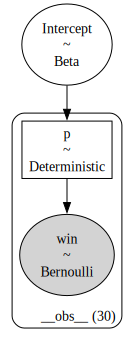

In [6]:
mod1.build()
mod1.graph()

In [7]:
idata1 = mod1.fit(draws=2000)

Modeling the probability that win==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [8]:
idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
import arviz as az
az.summary(idata1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.72,0.077,0.576,0.865,0.001,0.001,3450.0,5146.0,1.0


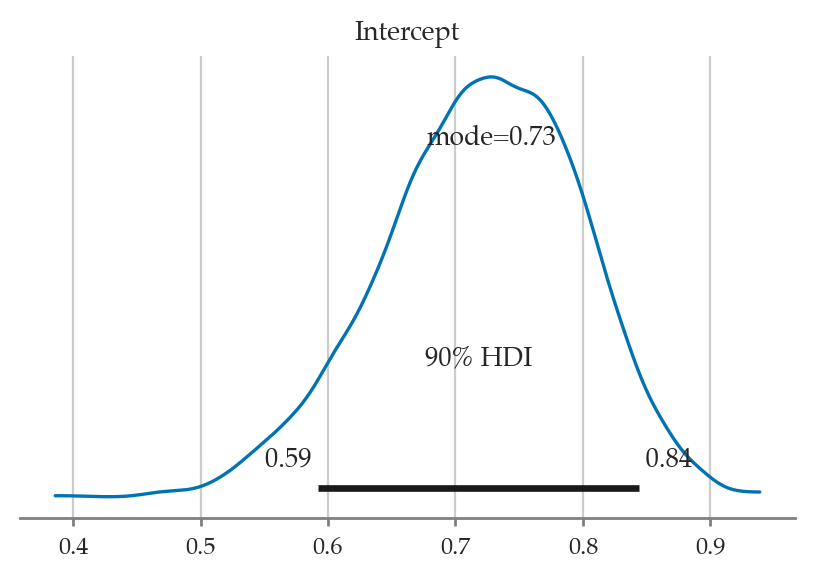

In [10]:
az.plot_posterior(idata1, var_names="Intercept", point_estimate="mode", hdi_prob=0.9);

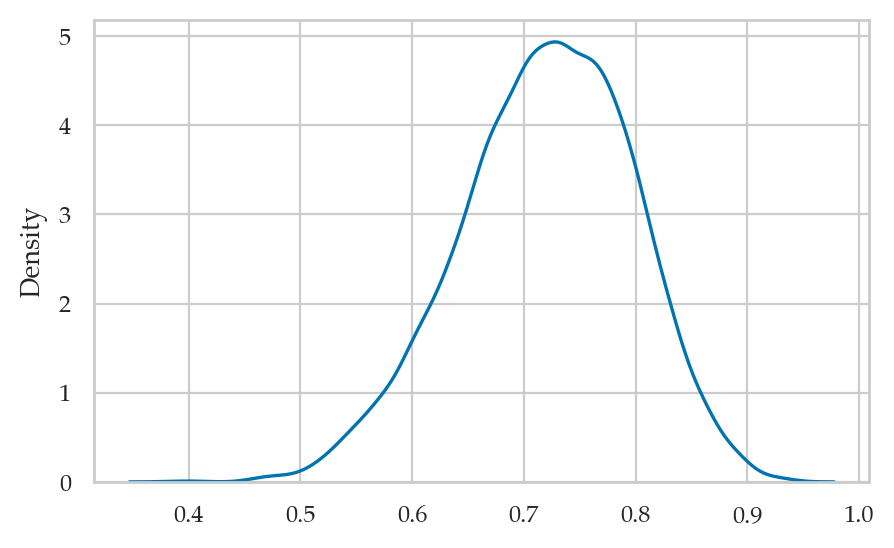

In [11]:
# ALT. manual plot of posterior density
post = az.extract(idata1, group="posterior", var_names="Intercept").values
sns.kdeplot(x=post.flatten(), bw_adjust=1);

Sampling: [Intercept]


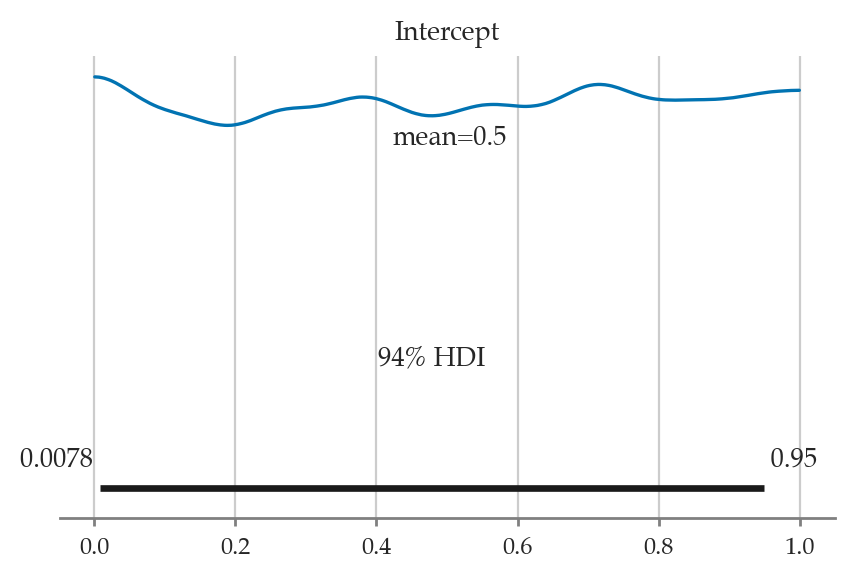

In [12]:
mod1.plot_priors();

In [13]:
# mod1.predict(idata1, kind="response")
# preds = az.extract(idata1, group="posterior_predictive", var_names="win").values
# sns.histplot(x=preds.sum(axis=0), stat="density")
# sns.kdeplot(x=post.mean(axis=0)*30)

### ALT. Declare a model in PyMC

In [14]:
import pymc as pm

with pm.Model() as model:
    # Specify the prior distribution of unknown parameter
    p = pm.Beta("p", alpha=1, beta=1)
    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=p, observed=dfcoin)
    # Sample from the posterior distribution
    idata1_alt = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [15]:
az.summary(idata1_alt)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.719,0.079,0.572,0.864,0.001,0.001,3407.0,5448.0,1.0


In [16]:
pred_dists = (pm.sample_prior_predictive(1000, model).prior_predictive["y_obs"].values,
              pm.sample_posterior_predictive(idata1, model).posterior_predictive["y_obs"].values)

Sampling: [p, y_obs]
Sampling: [p, y_obs]


Output()

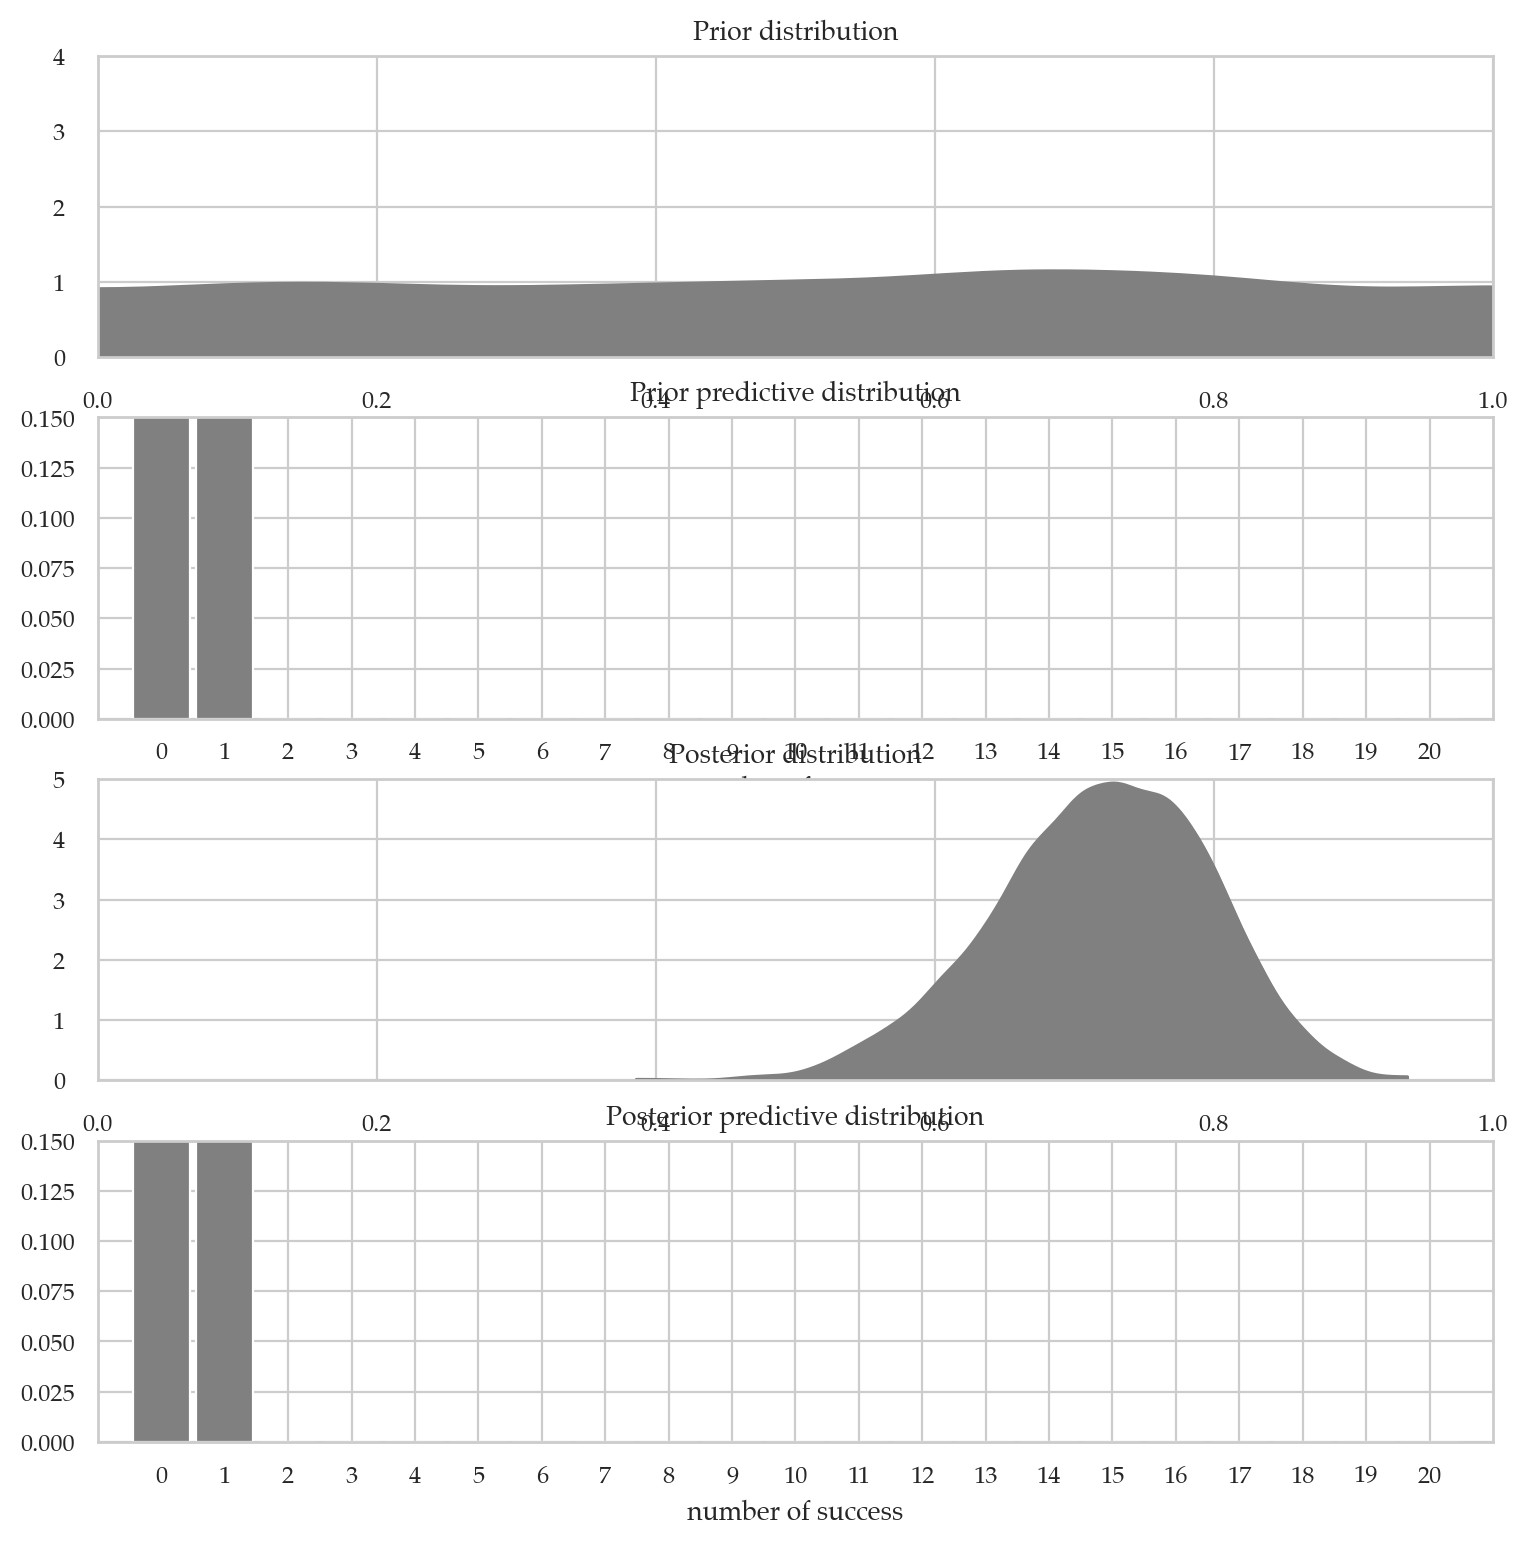

In [17]:
fig, axes = plt.subplots(4, 1, figsize=(9, 9))

for idx, n_d, dist in zip((1, 3), ("Prior", "Posterior"), pred_dists):
    az.plot_dist(dist.sum(-1), 
                 hist_kwargs={"color":"0.5", "bins":range(0, 22)},
                 ax=axes[idx])
    axes[idx].set_title(f"{n_d} predictive distribution", fontweight='bold')
    axes[idx].set_xlim(-1, 21)
    axes[idx].set_ylim(0, 0.15)
    axes[idx].set_xlabel("number of success")

az.plot_dist(pm.draw(p, 1000),
             plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[0])
axes[0].set_title("Prior distribution", fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 4)
axes[0].tick_params(axis='both', pad=7)
axes[0].set_xlabel("p")

az.plot_dist(idata1.posterior["Intercept"],
             plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1},
             ax=axes[2])
axes[2].set_title("Posterior distribution", fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 5)
axes[2].tick_params(axis='both', pad=7)
axes[2].set_xlabel("p");


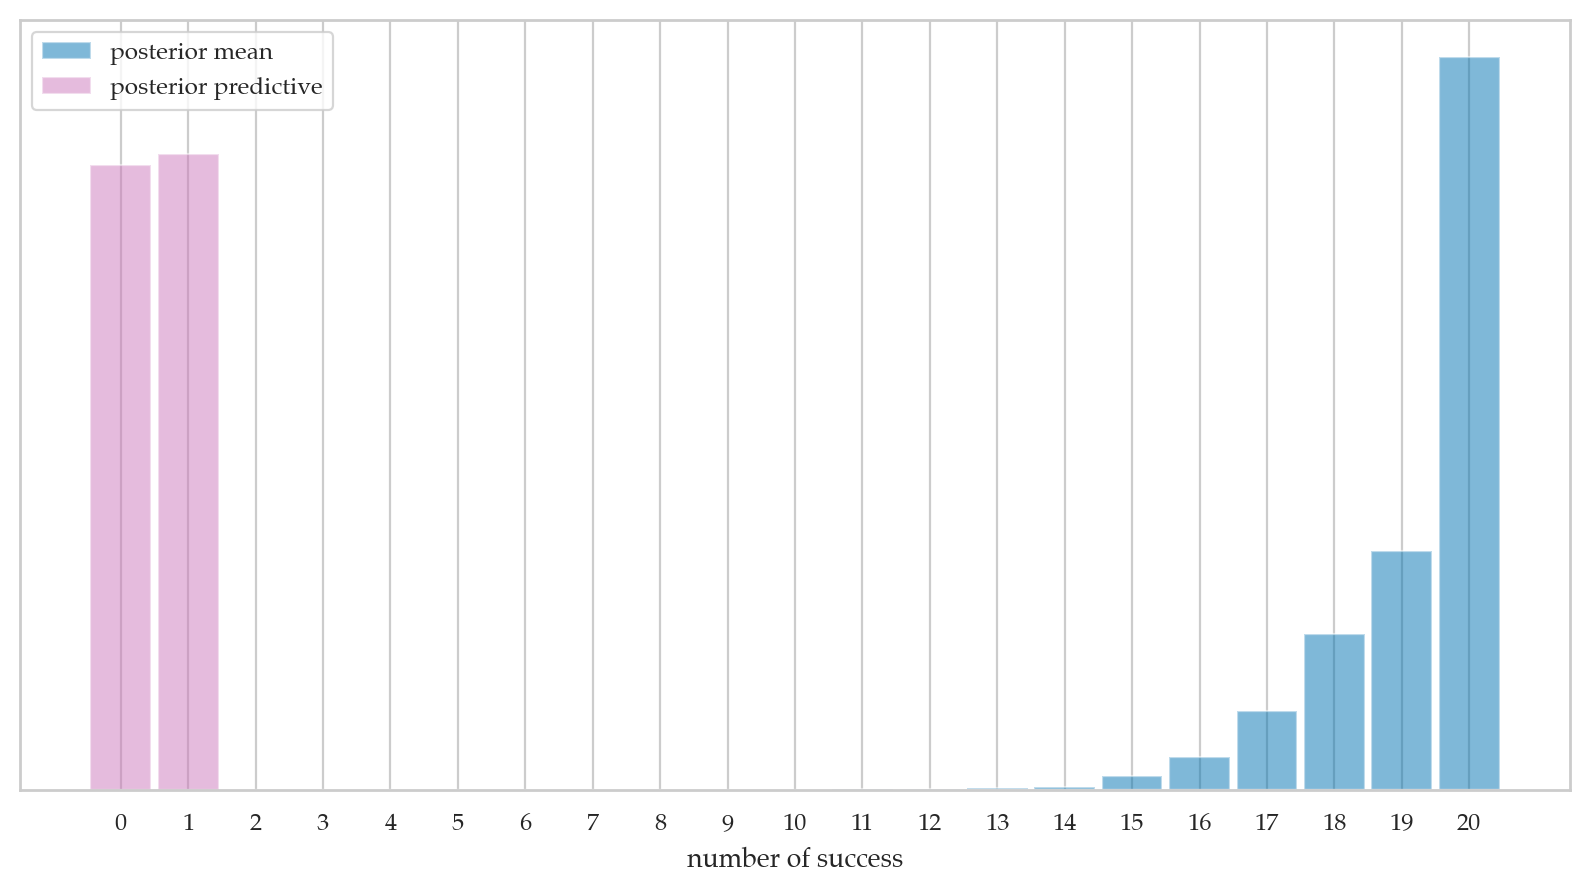

In [18]:
from scipy.stats import binom

predictions = (binom(n=1, p=idata1.posterior["Intercept"].mean()).rvs((4000, len(wins))),
               pred_dists[1])

for d, c, l in zip(predictions, ("C0", "C4"), ("posterior mean", "posterior predictive")):
    ax = az.plot_dist(d.sum(-1),
                      label=l,
                      figsize=(10, 5),
                      hist_kwargs={"alpha": 0.5, "color":c, "bins":range(0, 22)})
    ax.set_yticks([])
    ax.set_xlabel("number of success")

## Example 2: estimating the probability of a biased coin

## Discussion

### MCMC diagnostic plots

There are several Arviz plots we can use to check if the Markov Chain Monte Carlo chains were sampling from the posterior as expected, or ...

In [19]:
# az.plot_trace(idata);
# az.plot_trace(idata, kind="rank_bars");
# az.plot_trace(idata, kind="rank_vlines");

# plot_cap ~= partial regression plots?
# e.g. plot_cap(model_2, fitted_2, "weight", ax=ax);

### Choice of priors

Different priors lead to different posteriors.

See `Code 1.8 and Figure 1.7` in
[chp_01.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_01.ipynb)

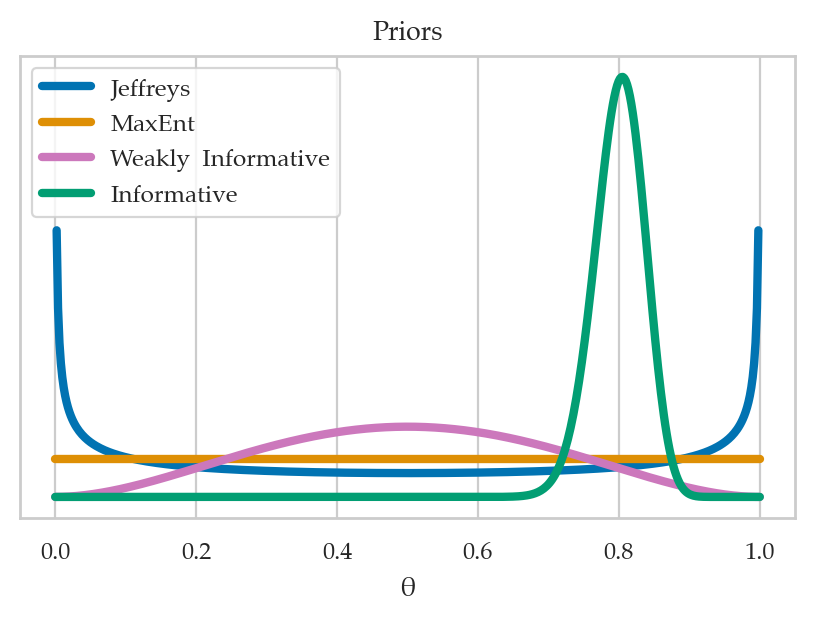

In [20]:
from scipy.stats import beta

x = np.linspace(0, 1, 500)
params = [(0.5, 0.5), (1, 1), (3,3), (100, 25)]

labels = ["Jeffreys", "MaxEnt", "Weakly  Informative",
          "Informative"]

_, ax = plt.subplots()
for (α, β), label, c in zip(params, labels, (0, 1, 4, 2)):
    pdf = beta.pdf(x, α, β)
    ax.plot(x, pdf, label=f"{label}", c=f"C{c}", lw=3)
    ax.set(yticks=[], xlabel="θ", title="Priors")
    ax.legend()
# plt.savefig("img/chp01/prior_informativeness_spectrum.png")

### Bayesian workflow

See also [chp_09.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_09.ipynb)